In [19]:
# Import all required libraries
import numpy as np
import matplotlib.pyplot as plt
import mltools as ml
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

np.random.seed(0)
%matplotlib inline

In [21]:
# Load the training data
X = np.genfromtxt('data/X_train.txt', delimiter=None)
Y = np.genfromtxt('data/Y_train.txt', delimiter=None)

# And the test features
Xte = np.genfromtxt('data/X_test.txt', delimiter=None)

#split data into 80/20 training and validation sets
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y, 0.80)

In [56]:
def evaluate_ROC_AUC(clf, Xtr, Ytr, Xva, Yva):
    predsTr = clf.predict_proba(Xtr)
    fprTr, tprTr, thresholdsTr = metrics.roc_curve(Ytr, predsTr[:, 1])
    predsVa = clf.predict_proba(Xva)
    fprVa, tprVa, thresholdsVa = metrics.roc_curve(Yva, predsVa[:, 1])
    roc_aucTr = roc_auc_score(Ytr, predsTr[:, 1])
    roc_aucVa = roc_auc_score(Yva, predsVa[:, 1])
    print("Training Accuracy:",metrics.accuracy_score(Ytr, clf.predict(Xtr)))
    print("Validation Accuracy:",metrics.accuracy_score(Yva, clf.predict(Xva)))
    plt.figure()
    lw = 2
    plt.plot(fprTr, tprTr,
             lw=lw, label='Training ROC curve (area = %0.2f)' % roc_aucTr)
    plt.plot(fprVa, tprVa,
             lw=lw, label='Validation ROC curve (area = %0.2f)' % roc_aucVa)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

### Baseline Predictions (Decision Tree)

In [65]:
clfDtree = DecisionTreeClassifier(
                criterion="gini",
                max_depth=8,
                min_samples_split=0.05)
clfDtree.fit(Xtr, Ytr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Training Accuracy: 0.6872875
Validation Accuracy: 0.6874


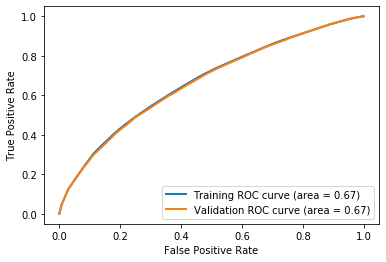

In [66]:
evaluate_ROC_AUC(clfDtree, Xtr, Ytr, Xva, Yva)

### Gradient Boosted Trees

In [41]:
models = list()
degrees = [i for i in range(1, 10)]

for degree in degrees:
    boostedTree = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=degree),
        n_estimators = 92,
        algorithm = "SAMME.R",
        learning_rate = 1.0)
    boostedTree.fit(Xtr, Ytr)
    models.append(boostedTree)


In [42]:
maxAuc = 0
maxModel = 0
for i, model in enumerate(models):
    predsTr = model.predict_proba(Xtr)
    fprTr, tprTr, thresholdsTr = metrics.roc_curve(Ytr, predsTr[:, 1])
    predsVa = model.predict_proba(Xva)
    fprVa, tprVa, thresholdsVa = metrics.roc_curve(Yva, predsVa[:, 1])
    roc_aucTr = roc_auc_score(Ytr, predsTr[:, 1])
    roc_aucVa = roc_auc_score(Yva, predsVa[:, 1])
    if maxAuc < roc_aucVa:
        maxAuc = roc_aucVa
        maxModel = i
        
model = models[maxModel]
print("Best max_depth:", degrees[maxModel])

Best max_depth: 7


In [62]:
clfBoostedTree = AdaBoostClassifier(
                    DecisionTreeClassifier(max_depth=7),
                    algorithm = "SAMME.R",
                    learning_rate = 0.5,
                    n_estimators = 52)
clfBoostedTree.fit(Xtr, Ytr)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=7,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

Training Accuracy: 0.76174375
Validation Accuracy: 0.731475


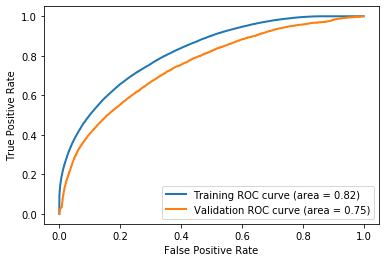

In [63]:
evaluate_ROC_AUC(clfBoostedTree, Xtr, Ytr, Xva, Yva)

### KNN Classifier

In [67]:
clfKnn = KNeighborsClassifier(
            n_neighbors=4,
            algorithm="ball_tree",
            weights="uniform")
clfKnn.fit(Xtr, Ytr)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

Training Accuracy: 0.80209375
Validation Accuracy: 0.719875


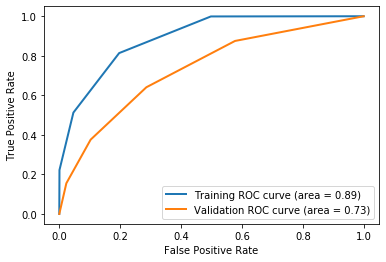

In [68]:
evaluate_ROC_AUC(clfKnn, Xtr, Ytr, Xva, Yva)

### Neural Network (Multi-layer Perceptron) Classifier

In [69]:
clf = MLPClassifier(
        max_iter=100,
        activation="relu",
        alpha=0.0001,
        hidden_layer_sizes=(50,100,50),
        learning_rate="constant",
        solver="adam")
clf.fit(Xtr, Ytr)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Training Accuracy: 0.69246875
Validation Accuracy: 0.693


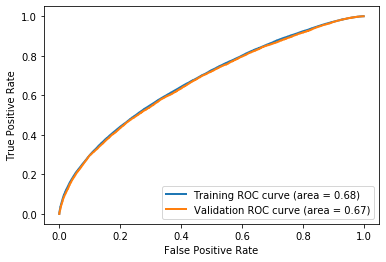

In [70]:
evaluate_ROC_AUC(clf, Xtr, Ytr, Xva, Yva)